Compare to P-Net:


|                         | accuracy | auc      | aupr     | f1       | precision | recall   |
|-------------------------|----------|----------|----------|----------|-----------|----------|
| P-net_ALL               | 0.838235 | 0.926789 | 0.878182 | 0.755556 | 0.750000  | 0.761194 |
| Logistic Regression_ALL | 0.833333 | 0.881904 | 0.808983 | 0.725806 | 0.789474  | 0.671642 |

In [1]:
import time

import numpy as np
import torch, torch_geometric.transforms as T, torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

from torch_geometric.loader import DataLoader

import pytorch_lightning as pl

import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, roc_curve, auc, average_precision_score, \
    f1_score, accuracy_score, precision_score, recall_score

from cancernet.arch import GATNet
from cancernet.util import ProgressBar, InMemoryLogger
from cancernet import PnetDataSet

## Load dataset

In [2]:
dataset = PnetDataSet(
    root="./data/prostate",
    name="prostate_graph_humanbase",
    #files={'graph_file': "global.geneSymbol.gz"},
    edge_tol=0.5,
    pre_transform=T.Compose([T.GCNNorm(add_self_loops=False), T.ToSparseTensor(remove_edge_index=False)]))

Ensure consistent and reproducible train/validation/test split.

In [3]:
dataset.split_index_by_file(
    train_fp="./data/prostate/splits/training_set_0.csv",
    valid_fp="./data/prostate/splits/validation_set.csv",
    test_fp="./data/prostate/splits/test_set.csv"
)

In [4]:
dataset

PnetDataset(len=1011, graph=prostate_graph_humanbase, num_edges=15080, edge_tol=0.50)

Check whether test indices are fixed. 

Should be `[764, 865, 136, 968, 847, 155, 961, 998, 23, 112]`

In [5]:
dataset.test_idx[0:10]

[764, 865, 136, 968, 847, 155, 961, 998, 23, 112]

## Train

Set up hyperparameters, choose device, ...

In [6]:
n_epochs = 100
batch_size = 10
lr = 0.01

# keep everything reproducible!
torch.manual_seed(0)

Prepare data.

In [7]:
train_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(dataset.train_idx),
    drop_last=True,
)
valid_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(dataset.valid_idx),
    drop_last=True,
)

Create model.

In [8]:
model = GATNet(dims=[3, 64, 256, 128], lr=lr)

Train.

In [9]:
t0 = time.time()
logger = InMemoryLogger()
trainer = pl.Trainer(accelerator="auto", max_epochs=n_epochs, callbacks=[ProgressBar()], logger=logger)
trainer.fit(model, train_loader, valid_loader)
print(f"Training took {time.time() - t0:.1f} seconds.")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/mnt/home/ttesileanu/miniconda3/envs/cancerenv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /mnt/home/ttesileanu/Documents/research/deep-cancer-conda/demos/in_memory/version_1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type            | Params
--------------------------------------------
0 | prop1   | GCNConv         | 256   
1 | prop2   | GCNConv         | 16.6 K
2 | fc1     | Linear          | 32.9 K
3 | fc2     | Linear          | 258   
4 | m       | LogSoftmax      | 0     
5 | gate_nn | Sequential      | 8.3 K 
6 | pool    | GlobalAttention | 8.3 K 
--------------------------------------------
58.3 K    Trainable params
0         Non-trainable

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training took 149.2 seconds.


Visualize training trajectory.

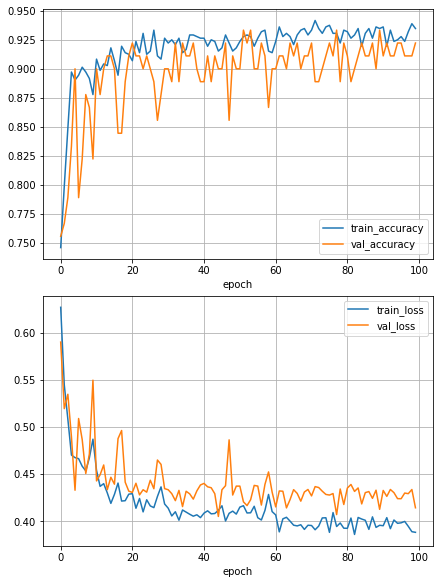

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), constrained_layout=True)
logger.metrics_df.plot("epoch", ["train_accuracy", "val_accuracy"], ax=ax1)
ax1.grid()

logger.metrics_df.plot("epoch", ["train_loss", "val_loss"], ax=ax2)
ax2.grid()

Define helper function for calculating ROC curve and AUC.

In [11]:
def get_roc(model, loader, seed=1):
    # keep everything reproducible!
    torch.manual_seed(seed)

    outs = []
    ys = []
    device = next(iter(model.parameters())).device
    for tb in loader:
        tb = tb.to(device)
        outs.append(torch.exp(model(tb)).detach().cpu().clone().numpy())
        ys.append(tb.y.detach().cpu().clone().numpy())

    outs = np.concatenate(outs)
    ys = np.concatenate(ys)

    fpr, tpr, _ = roc_curve(ys, outs[:, 1])
    auc_value = auc(fpr, tpr)

    return fpr, tpr, auc_value, ys, outs

Calculate and show ROC and AUC.

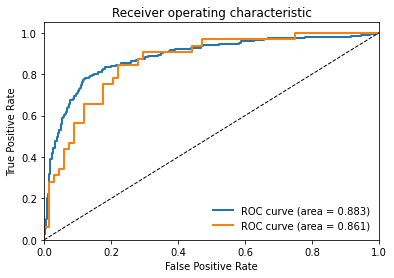

In [12]:
fpr_train, tpr_train, train_auc, _, _ = get_roc(model, train_loader)
fpr_valid, tpr_valid, valid_auc, _, _ = get_roc(model, valid_loader)

fig, ax = plt.subplots()
ax.plot(
    fpr_train, tpr_train, lw=2, label="ROC curve (area = %0.3f)" % train_auc,
)
ax.plot(
    fpr_valid, tpr_valid, lw=2, label="ROC curve (area = %0.3f)" % valid_auc,
)
ax.plot([0, 1], [0, 1], color="black", lw=1, linestyle="--")
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Receiver operating characteristic")
ax.legend(loc="lower right", frameon=False)

Check performance on test set.

In [13]:
test_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(dataset.test_idx),
    drop_last=True,
)
fpr_test, tpr_test, test_auc, ys, outs = get_roc(model, test_loader)

print('accuracy', accuracy_score(ys, outs[:, 1]>0.5))
print('auc', test_auc)
print('aupr', average_precision_score(ys, outs[:, 1]))
print('f1', f1_score(ys, outs[:, 1]>0.5))
print('precision', precision_score(ys, outs[:, 1]>0.5))
print('recall', recall_score(ys, outs[:, 1]>0.5))

accuracy 0.85
auc 0.9176843057440073
aupr 0.8575921316579029
f1 0.7540983606557378
precision 0.8214285714285714
recall 0.696969696969697
